In [1]:
!pip install scikit-learn==1.5.2 imbalanced-learn==0.12.3

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.14.0
    Uninstalling imbalanced-learn-0.14.0:
      Successfully uninstalled imbalanced-learn-0.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


# **Load Dataset**

In [3]:
# 📂 2️⃣ Load Dataset
# -------------------
# Load your air pollution dataset and check its shape and columns.

df = pd.read_csv('/content/my_ap_dataset.csv')
print("✅ Shape:", df.shape)
print("✅ Columns:", df.columns.tolist())


✅ Shape: (155405, 11)
✅ Columns: ['date', 'Station code', 'Address', 'Latitude', 'Longitude', 'SO2', 'NO2', 'CO', 'O3', 'PM2.5', 'PM10']


# **Data Preprocessing**

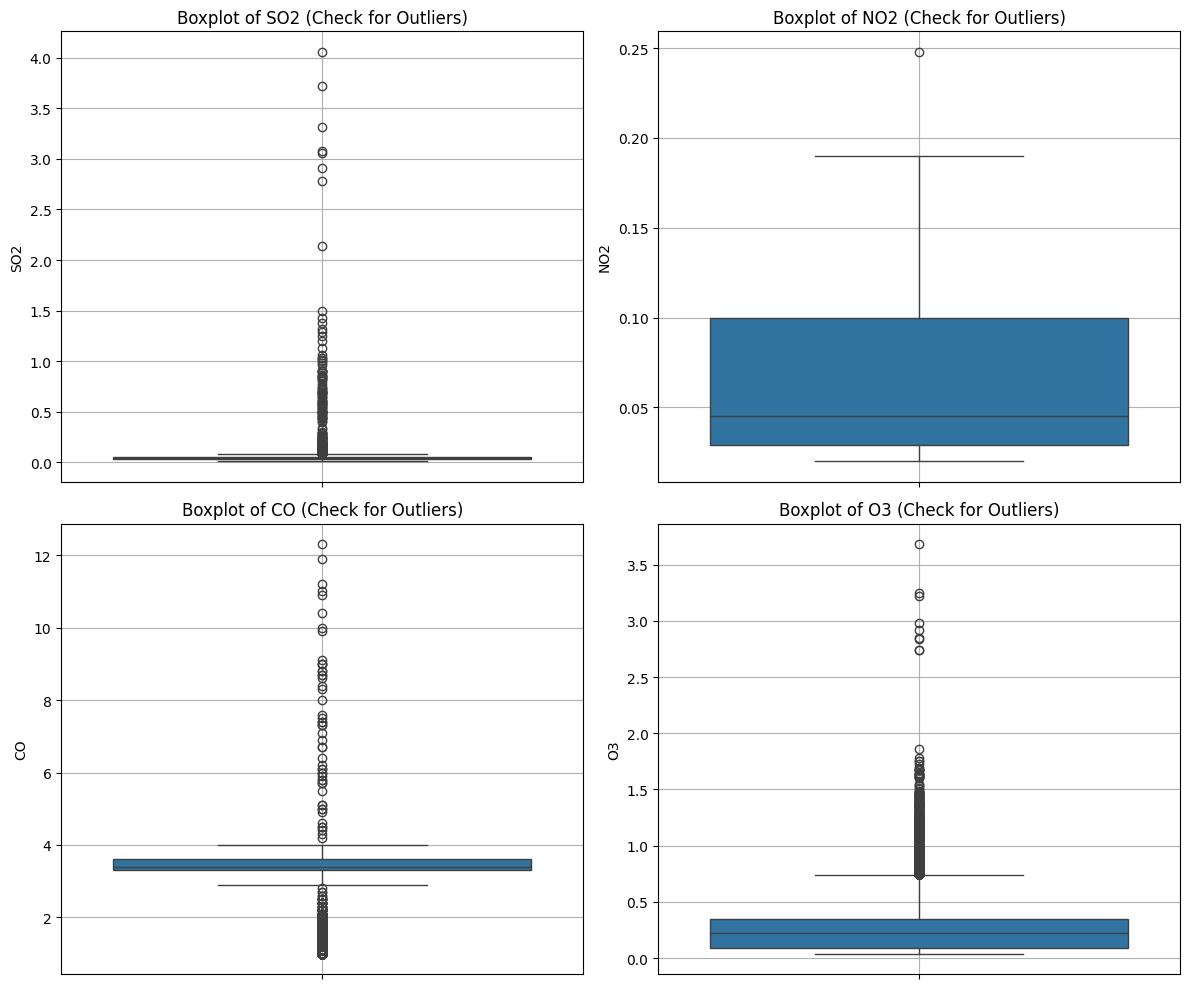

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of pollutants to check for outliers
pollutants = ['SO2', 'NO2', 'CO', 'O3']

# Set up the plot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(pollutants):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} (Check for Outliers)')
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [5]:
for col in ['SO2','NO2','CO','O3']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    df[col] = df[col].clip(lower, upper)


In [6]:


# 2️⃣ Function to calculate AQI_Category using PM2.5 and PM10
def categorize_pm(pm25, pm10):
    """
    Estimate AQI Category using PM2.5 and PM10.
    Uses the worse pollutant (max of both) for category assignment.
    Based on Indian AQI standards.
    """
    if not pd.isna(pm25) and not pd.isna(pm10):
        aqi = max(pm25, pm10)  # use the more polluted one
    elif not pd.isna(pm25):
        aqi = pm25
    elif not pd.isna(pm10):
        aqi = pm10
    else:
        return np.nan

    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Satisfactory"
    elif aqi <= 200:
        return "Moderate"
    elif aqi <= 300:
        return "Poor"
    elif aqi <= 400:
        return "Very Poor"
    else:
        return "Severe"

# 3️⃣ Apply function
df["AQI_Category"] = df.apply(lambda row: categorize_pm(row["PM2.5"], row["PM10"]), axis=1)

# 4️⃣ Show class distribution
class_counts = df["AQI_Category"].value_counts()
print("✅ AQI Category Distribution:")
print(class_counts)

# 5️⃣ (Optional) Save the dataset with AQI_Category
df.to_csv("dataset_with_aqi_category.csv", index=False)
print("\n💾 File saved as 'dataset_with_aqi_category.csv'")


✅ AQI Category Distribution:
AQI_Category
Satisfactory    82464
Moderate        64817
Good             7616
Poor              476
Very Poor          32
Name: count, dtype: int64

💾 File saved as 'dataset_with_aqi_category.csv'


In [7]:
df.sample(5)

,date,Station code,Address,Latitude,Longitude,SO2,NO2,CO,O3,PM2.5,PM10,AQI_Category
73545,7/7/2019 19:00,102,"Uttara, Dhaka, Bangladesh",23.851008,90.371365,0.02,0.099,3.2,0.4300,58,95,Satisfactory
41700,10/21/2021 3:00,101,"Kuril Bishow Road, Dhaka, Bangladesh",23.820612,90.421011,0.03,0.047,3.8,0.0525,71,114,Moderate
62983,4/11/2018 13:00,102,"Uttara, Dhaka, Bangladesh",23.851008,90.371365,0.03,0.020,3.4,0.4500,73,52,Satisfactory
147521,1/21/2022 22:00,103,"Tongi, Gazipur, Bangladesh",23.894144,90.404219,0.03,0.036,3.7,0.0545,70,70,Satisfactory
99826,7/23/2022 11:00,102,"Uttara, Dhaka, Bangladesh",23.851008,90.371365,0.04,0.020,3.1,0.1800,71,109,Moderate


📊 Class counts:
 AQI_Category
Satisfactory    82464
Moderate        64817
Good             7616
Poor              476
Very Poor          32
Name: count, dtype: int64


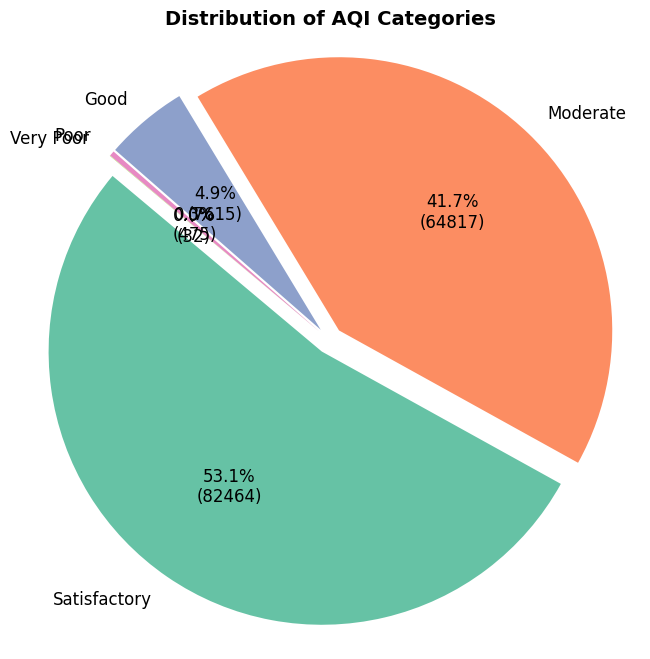

/tmp/ipython-input-1374425924.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")


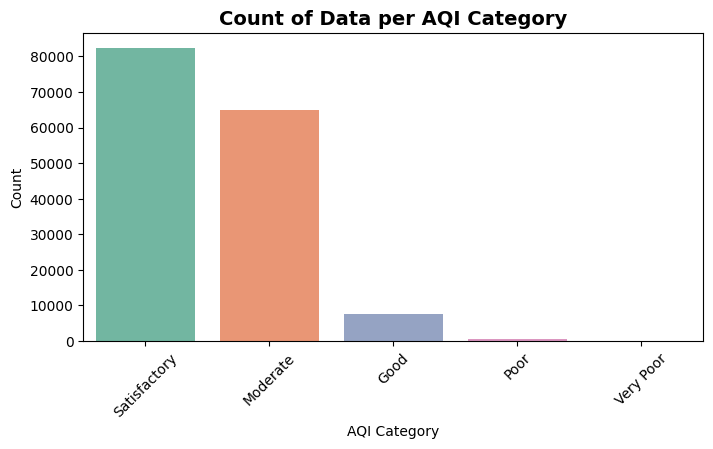

In [8]:
# 🥧 6️⃣.1️⃣ Improved Visualization of AQI Category Distribution
# --------------------------------------------------------------
class_counts = df['AQI_Category'].value_counts()
print("📊 Class counts:\n", class_counts)

# 🎨 Define colors (optional)
colors = sns.color_palette("Set2", len(class_counts))

# 🥧 Pie Chart
plt.figure(figsize=(8,8))
explode = [0.05] * len(class_counts)  # separate each slice slightly
plt.pie(
    class_counts.values,
    labels=class_counts.index,
    autopct=lambda p: f'{p:.1f}%\n({int(p*sum(class_counts)/100)})',
    colors=colors,
    startangle=140,
    explode=explode,
    textprops={'fontsize': 12}
)
plt.title("Distribution of AQI Categories", fontsize=14, fontweight='bold')
plt.axis('equal')  # makes the pie chart circular
plt.show()

# 📊 Bar Chart for Clearer View
plt.figure(figsize=(8,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")
plt.title("Count of Data per AQI Category", fontsize=14, fontweight='bold')
plt.xlabel("AQI Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


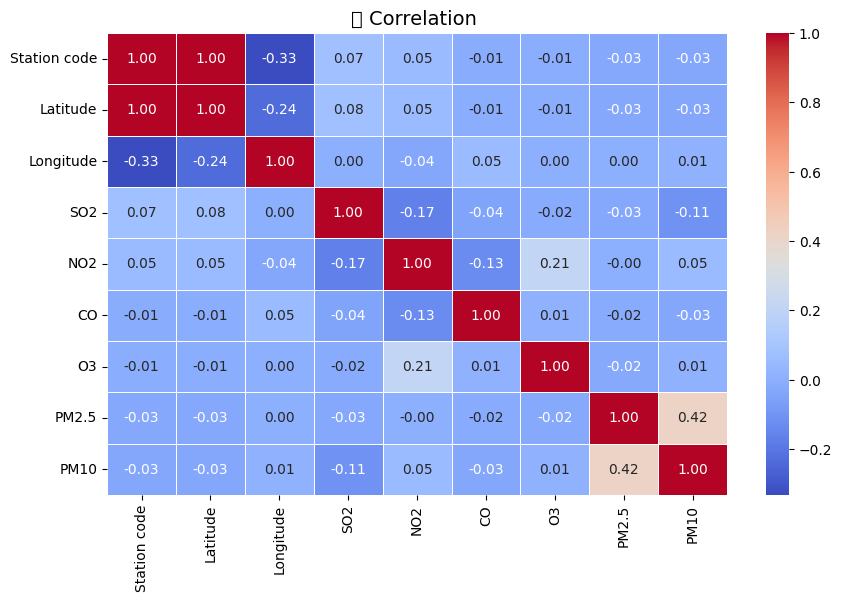

In [9]:
# 📊 Correlation Heatmap (with correlation values)
# -----------------------------------------------

# Keep only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Plot correlation heatmap with values
plt.figure(figsize=(10, 6))
sns.heatmap(
    numeric_df.corr(),
    annot=True,        # ✅ show numeric correlation values
    cmap='coolwarm',   # color palette
    fmt=".2f",         # format numbers to 2 decimals
    linewidths=0.5     # thin line between cells for readability
)
plt.title("📈 Correlation ", fontsize=14)
plt.show()


# *Drop AQI column*

In [10]:
df.head()

,date,Station code,Address,Latitude,Longitude,SO2,NO2,CO,O3,PM2.5,PM10,AQI_Category
0,1/1/2017 0:00,101,"Kuril Bishow Road, Dhaka, Bangladesh",23.820612,90.421011,0.04,0.059,2.85,0.0525,57,73,Satisfactory
1,1/1/2017 1:00,101,"Kuril Bishow Road, Dhaka, Bangladesh",23.820612,90.421011,0.04,0.058,2.85,0.0525,59,71,Satisfactory
2,1/1/2017 2:00,101,"Kuril Bishow Road, Dhaka, Bangladesh",23.820612,90.421011,0.04,0.056,2.85,0.0525,59,70,Satisfactory
3,1/1/2017 3:00,101,"Kuril Bishow Road, Dhaka, Bangladesh",23.820612,90.421011,0.04,0.056,2.85,0.0525,58,70,Satisfactory
4,1/1/2017 4:00,101,"Kuril Bishow Road, Dhaka, Bangladesh",23.820612,90.421011,0.03,0.051,2.85,0.0525,61,69,Satisfactory


In [11]:
# 🧽 5️⃣ Remove AQI Column (to Prevent Data Leakage)
# ---------------------------------------------------
# The AQI column directly relates to the target, so we remove it.

if 'AQI' in df.columns:
    df = df.drop(columns=['AQI'])


# *Handle missing & Duplicate value*

In [12]:
# 🧼 6️⃣ Clean Missing and Duplicate Data
# ---------------------------------------
# Drop any rows with missing or duplicate values.

df = df.dropna().drop_duplicates()
print("✅ Cleaned shape:", df.shape)
print("✅ Class distribution:\n", df['AQI_Category'].value_counts())


✅ Cleaned shape: (155405, 12)
✅ Class distribution:
 AQI_Category
Satisfactory    82464
Moderate        64817
Good             7616
Poor              476
Very Poor          32
Name: count, dtype: int64


# **Data Split**

In [13]:
df.head()

,date,Station code,Address,Latitude,Longitude,SO2,NO2,CO,O3,PM2.5,PM10,AQI_Category
0,1/1/2017 0:00,101,"Kuril Bishow Road, Dhaka, Bangladesh",23.820612,90.421011,0.04,0.059,2.85,0.0525,57,73,Satisfactory
1,1/1/2017 1:00,101,"Kuril Bishow Road, Dhaka, Bangladesh",23.820612,90.421011,0.04,0.058,2.85,0.0525,59,71,Satisfactory
2,1/1/2017 2:00,101,"Kuril Bishow Road, Dhaka, Bangladesh",23.820612,90.421011,0.04,0.056,2.85,0.0525,59,70,Satisfactory
3,1/1/2017 3:00,101,"Kuril Bishow Road, Dhaka, Bangladesh",23.820612,90.421011,0.04,0.056,2.85,0.0525,58,70,Satisfactory
4,1/1/2017 4:00,101,"Kuril Bishow Road, Dhaka, Bangladesh",23.820612,90.421011,0.03,0.051,2.85,0.0525,61,69,Satisfactory


# *Balance the Dataset*

In [14]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# --- 1️⃣ Encode target ---
df['AQI_Label'] = LabelEncoder().fit_transform(df['AQI_Category'])

# --- 2️⃣ Spatial features ---
df['Lat_region'] = df['Latitude'].round(2)
df['Lon_region'] = df['Longitude'].round(2)
df['Location_zone'] = df['Lat_region'].astype(str) + "_" + df['Lon_region'].astype(str)

# --- 3️⃣ Interaction features ---
df['NO2_SO2_ratio'] = df['NO2'] / (df['SO2'] + 1e-6)
df['CO_O3_ratio'] = df['CO'] / (df['O3'] + 1e-6)
df['NO2_CO'] = df['NO2'] * df['CO']

# --- 4️⃣ Temporal features ---
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['month'].apply(get_season)

# --- 5️⃣ Encode categorical features ---
for col in ['Location_zone', 'season']:
    df[col] = LabelEncoder().fit_transform(df[col])

# --- 6️⃣ Define features and target ---
feature_cols = [
    'Latitude', 'Longitude', 'SO2', 'NO2', 'CO', 'O3',
    'Lat_region', 'Lon_region', 'Location_zone',
    'NO2_SO2_ratio', 'CO_O3_ratio', 'NO2_CO',
    'hour', 'day', 'month', 'season'
]

X = df[feature_cols]
y = df['AQI_Label']

# --- 7️⃣ Balance target classes to 20k per class ---
target_count = 20000
df_list = []

# Combine features and target temporarily for balancing
df_temp = X.copy()
df_temp['AQI_Label'] = y

for label in y.unique():
    subset = df_temp[df_temp['AQI_Label'] == label]
    if label in [1, 3]:  # undersample these classes
        subset = subset.sample(target_count, random_state=42)
    else:  # oversample other classes
        subset = subset.sample(target_count, replace=True, random_state=42)
    df_list.append(subset)

# Concatenate all classes to get balanced dataset
df_balanced = pd.concat(df_list).reset_index(drop=True)

# --- 8️⃣ Separate features and target again ---
X_balanced = df_balanced[feature_cols]
y_balanced = df_balanced['AQI_Label']

# --- 9️⃣ Check balanced class distribution ---
print("✅ Class distribution after balancing:")
print(y_balanced.value_counts())


✅ Class distribution after balancing:
AQI_Label
3    20000
1    20000
0    20000
2    20000
4    20000
Name: count, dtype: int64


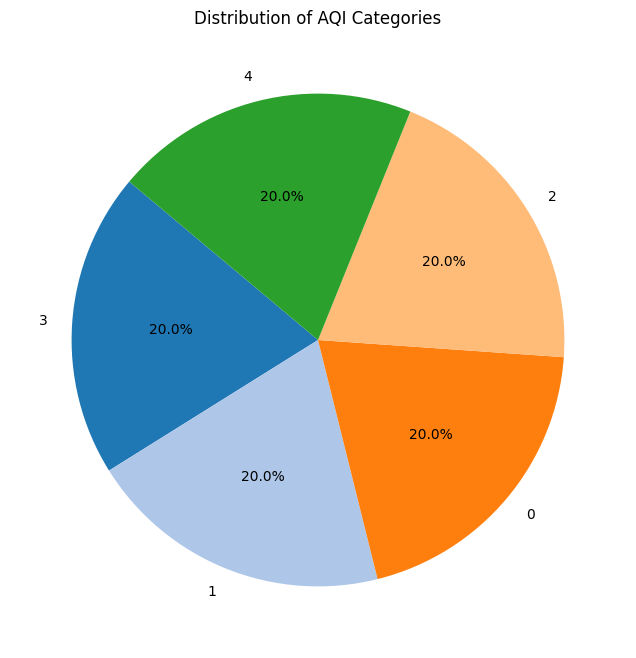

In [15]:
import matplotlib.pyplot as plt

# Count of each class
counts = df_balanced['AQI_Label'].value_counts()

# Plot pie chart
plt.figure(figsize=(8,8))
plt.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',  # Show percentage
    startangle=140,
    colors=plt.cm.tab20.colors  # Optional: nice color palette
)
plt.title("Distribution of AQI Categories")
plt.show()


# **Train Test Validation**

In [16]:
# Assume df_balanced is your balanced DataFrame after oversampling/undersampling

# 1️⃣ Define features and target
X_balanced = df_balanced.drop(columns=['AQI_Label'])
y_balanced = df_balanced['AQI_Label']

# 2️⃣ Train/Validation/Test split → 70% / 15% / 15%
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Train: (70000, 16), Validation: (15000, 16), Test: (15000, 16)


In [17]:
X_balanced.head()

,Latitude,Longitude,SO2,NO2,CO,O3,Lat_region,Lon_region,Location_zone,NO2_SO2_ratio,CO_O3_ratio,NO2_CO,hour,day,month,season
0,23.820612,90.421011,0.05,0.025,3.2,0.11,23.82,90.42,0,0.499990,29.090645,0.0800,8,8,8,2
1,23.851008,90.371365,0.04,0.048,3.9,0.04,23.85,90.37,1,1.199970,97.497563,0.1872,2,18,12,3
2,23.894144,90.404219,0.02,0.096,3.4,0.44,23.89,90.40,2,4.799760,7.727255,0.3264,9,22,9,0
3,23.894144,90.404219,0.02,0.095,3.2,0.28,23.89,90.40,2,4.749763,11.428531,0.3040,4,15,9,0
4,23.820612,90.421011,0.03,0.160,3.3,0.28,23.82,90.42,0,5.333156,11.785672,0.5280,23,23,12,3


In [18]:
y_balanced.sample(10)

,AQI_Label
78027,2
55179,0
91331,4
70003,2
51384,0
56624,0
19255,3
95326,4
95060,4
41093,0


In [23]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00



📊 RandomForest Validation Accuracy: 0.8375
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      3000
           1       0.67      0.67      0.67      3000
           2       0.99      1.00      1.00      3000
           3       0.69      0.60      0.64      3000
           4       1.00      1.00      1.00      3000

    accuracy                           0.84     15000
   macro avg       0.83      0.84      0.83     15000
weighted avg       0.83      0.84      0.83     15000


📊 ExtraTrees Validation Accuracy: 0.8432
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      3000
           1       0.66      0.69      0.68      3000
           2       1.00      1.00      1.00      3000
           3       0.68      0.62      0.65      3000
           4       1.00      1.00      1.00      3000

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84  

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



📊 AdaBoost Validation Accuracy: 0.4223
              precision    recall  f1-score   support

           0       0.33      0.38      0.36      3000
           1       0.29      0.20      0.24      3000
           2       0.34      0.49      0.40      3000
           3       0.40      0.34      0.37      3000
           4       0.83      0.69      0.76      3000

    accuracy                           0.42     15000
   macro avg       0.44      0.42      0.42     15000
weighted avg       0.44      0.42      0.42     15000



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:34:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 XGBoost Validation Accuracy: 0.7823
              precision    recall  f1-score   support

           0       0.69      0.82      0.74      3000
           1       0.60      0.57      0.58      3000
           2       0.97      1.00      0.98      3000
           3       0.63      0.53      0.58      3000
           4       1.00      1.00      1.00      3000

    accuracy                           0.78     15000
   macro avg       0.78      0.78      0.78     15000
weighted avg       0.78      0.78      0.78     15000

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 16
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] 

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



📊 LogisticRegression Validation Accuracy: 0.4211
              precision    recall  f1-score   support

           0       0.39      0.40      0.40      3000
           1       0.32      0.20      0.25      3000
           2       0.41      0.50      0.45      3000
           3       0.35      0.25      0.29      3000
           4       0.53      0.75      0.63      3000

    accuracy                           0.42     15000
   macro avg       0.40      0.42      0.40     15000
weighted avg       0.40      0.42      0.40     15000


📊 KNN Validation Accuracy: 0.7339
              precision    recall  f1-score   support

           0       0.58      0.83      0.68      3000
           1       0.54      0.43      0.48      3000
           2       0.94      1.00      0.97      3000
           3       0.58      0.41      0.48      3000
           4       1.00      1.00      1.00      3000

    accuracy                           0.73     15000
   macro avg       0.73      0.73      0.72   

,Validation Accuracy
ExtraTrees,0.843200
RandomForest,0.837467
XGBoost,0.782267
LightGBM,0.759467
KNN,0.733933
GradientBoosting,0.668333
AdaBoost,0.422333
LogisticRegression,0.421067



⭐ Best Model: ExtraTrees

📊 Classification Report (Test)
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      3000
           1       0.67      0.67      0.67      3000
           2       0.99      1.00      1.00      3000
           3       0.68      0.63      0.65      3000
           4       1.00      1.00      1.00      3000

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



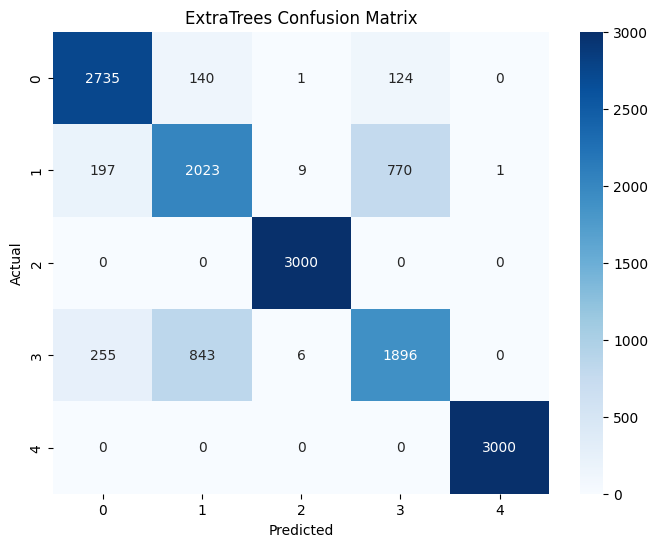

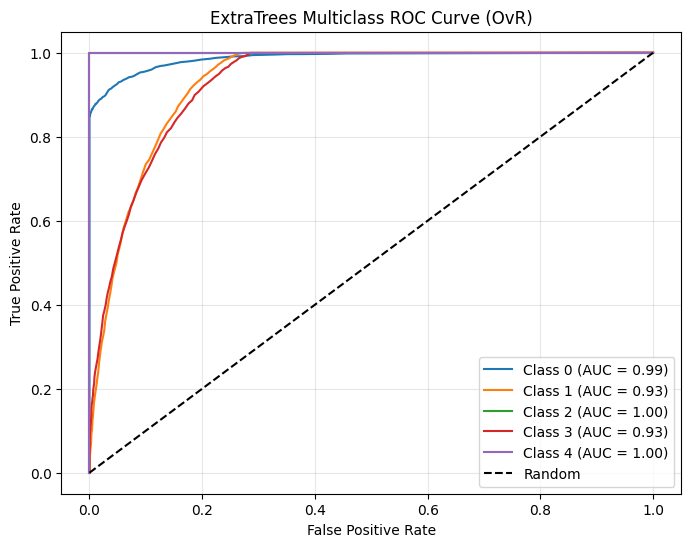


ROC-AUC Score (Macro OvR): 0.9693

🔹 5-Fold CV Accuracy: 0.8266 ± 0.0027


In [25]:
# =========================
# Imports
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import label_binarize

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# =========================
# Step 1: Define Models
# =========================
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42
    ),
    "LightGBM": LGBMClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier()
}

# =========================
# Step 2: Train & Validate
# =========================
trained_models = {}
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model

    y_pred_val = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred_val)
    results[name] = acc

    print(f"\n📊 {name} Validation Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_pred_val))

# =========================
# Step 3: Summary Table
# =========================
df_results = (
    pd.DataFrame.from_dict(results, orient="index", columns=["Validation Accuracy"])
    .sort_values(by="Validation Accuracy", ascending=False)
)

print("\n✅ Validation Accuracy Summary")
display(df_results)

# =========================
# Step 4: Select Best Model
# =========================
best_model_name = df_results.index[0]   # automatic
best_model = trained_models[best_model_name]

print(f"\n⭐ Best Model: {best_model_name}")

# =========================
# Step 5: Test Evaluation
# =========================
y_pred_test = best_model.predict(X_test)

print("\n📊 Classification Report (Test)")
print(classification_report(y_test, y_pred_test))

# ---- Confusion Matrix ----
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"{best_model_name} Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# =========================
# Step 6: ROC-AUC (Binary & Multiclass Safe)
# =========================
n_classes = len(np.unique(y_test))
y_score = best_model.predict_proba(X_test)

plt.figure(figsize=(8, 6))

# ---- Binary Classification ----
if n_classes == 2:
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], "k--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{best_model_name} ROC Curve")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print(f"\nROC-AUC Score: {roc_auc:.4f}")

# ---- Multiclass Classification ----
else:
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)

    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{best_model_name} Multiclass ROC Curve (OvR)")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    roc_auc_macro = roc_auc_score(
        y_test,
        y_score,
        multi_class="ovr",
        average="macro"
    )

    print(f"\nROC-AUC Score (Macro OvR): {roc_auc_macro:.4f}")

# =========================
# Step 7: Cross-Validation
# =========================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=cv,
    scoring="accuracy"
)

print(
    f"\n🔹 5-Fold CV Accuracy: "
    f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}"
)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      3000
           1       0.67      0.67      0.67      3000
           2       0.99      1.00      1.00      3000
           3       0.68      0.63      0.65      3000
           4       1.00      1.00      1.00      3000

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



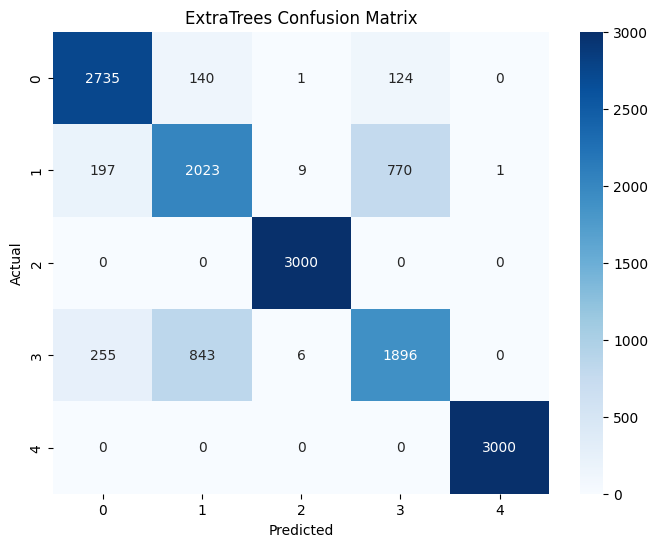

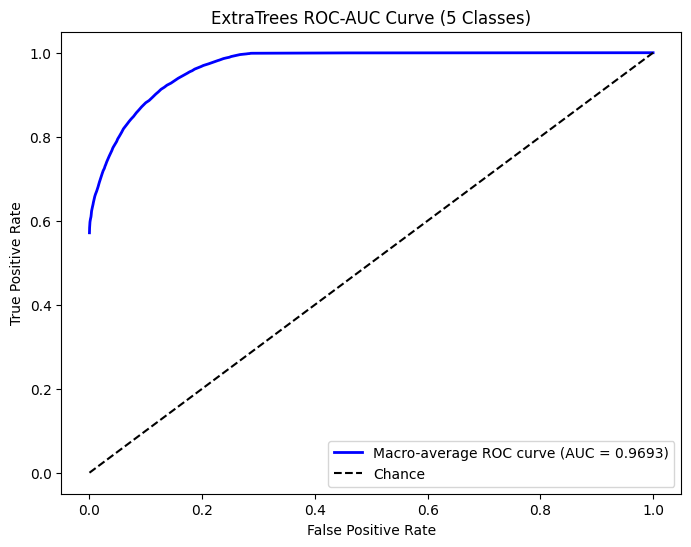


🔹 5-Fold Cross Validation Accuracy: 0.8266 ± 0.0027


In [26]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 🔹 Fit best model (ExtraTrees)
best_model = ExtraTreesClassifier(random_state=42)
best_model.fit(X_train, y_train)

# 🔹 Predict on test set
y_pred_test = best_model.predict(X_test)

# 🔹 Classification Report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred_test))

# 🔹 Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("ExtraTrees Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 🔹 ROC-AUC (macro-average for all classes)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score = best_model.predict_proba(X_test)
n_classes = y_test_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

# Plot single macro-average ROC curve
plt.figure(figsize=(8,6))
plt.plot(all_fpr, mean_tpr, color='b', label=f"Macro-average ROC curve (AUC = {macro_auc:.4f})", linewidth=2)
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ExtraTrees ROC-AUC Curve (5 Classes)")
plt.legend(loc="lower right")
plt.show()

# 🔹 5-Fold Cross Validation Accuracy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')
print(f"\n🔹 5-Fold Cross Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# 🔹 Fit best model (ExtraTrees)
best_model = ExtraTreesClassifier(random_state=42)
best_model.fit(X_train, y_train)

# 🔹 Binarize the test labels for multiclass ROC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_model.predict_proba(X_test)
n_classes = y_test_bin.shape[1]

# 🔹 Plot ROC curve for each class
plt.figure(figsize=(8,6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve (Multiclass, One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ✅ Compare all trained models on the test set
metrics_test_list = []

for name, model in models.items():
    y_pred_test = model.predict(X_test)

    metrics_test_list.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred_test),
        "Precision": precision_score(y_test, y_pred_test, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred_test, average='weighted', zero_division=0),
        "F1-score": f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
    })

# Create a comparison table
df_test_metrics = pd.DataFrame(metrics_test_list).sort_values(by='Accuracy', ascending=False)
print(df_test_metrics)


                Model  Accuracy  Precision    Recall  F1-score
1          ExtraTrees  0.843600   0.841019  0.843600  0.841974
0        RandomForest  0.840800   0.836752  0.840800  0.837472
4             XGBoost  0.784667   0.780231  0.784667  0.779904
5            LightGBM  0.764933   0.759586  0.764933  0.758415
7                 KNN  0.741000   0.737386  0.741000  0.728009
2    GradientBoosting  0.661267   0.651386  0.661267  0.653516
3            AdaBoost  0.423067   0.440636  0.423067  0.424713
6  LogisticRegression  0.413467   0.393829  0.413467  0.394834


In [28]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1️⃣ Define all models
models = {
    "Perceptron": Perceptron(max_iter=1000, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# 2️⃣ Train and evaluate
results = {}
scaler = StandardScaler()  # For neural networks

for name, model in models.items():
    # Scale features for neural networks
    if name in ["Perceptron", "MLP"]:
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        model.fit(X_train_scaled, y_train)
        y_pred_val = model.predict(X_val_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred_val = model.predict(X_val)

    # Metrics
    acc = accuracy_score(y_val, y_pred_val)
    results[name] = acc
    print(f"\n📊 {name} Validation Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_pred_val))

# 3️⃣ Summary table
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Validation Accuracy']).sort_values(by='Validation Accuracy', ascending=False)
print("\n✅ Validation Accuracy Summary:")
print(df_results)



📊 Perceptron Validation Accuracy: 0.3375
              precision    recall  f1-score   support

           0       0.32      0.36      0.34      3000
           1       0.24      0.25      0.25      3000
           2       0.22      0.17      0.19      3000
           3       0.25      0.19      0.21      3000
           4       0.56      0.72      0.63      3000

    accuracy                           0.34     15000
   macro avg       0.32      0.34      0.32     15000
weighted avg       0.32      0.34      0.32     15000


📊 MLP Validation Accuracy: 0.7059
              precision    recall  f1-score   support

           0       0.55      0.61      0.58      3000
           1       0.50      0.46      0.48      3000
           2       0.94      0.99      0.96      3000
           3       0.53      0.47      0.49      3000
           4       0.99      1.00      1.00      3000

    accuracy                           0.71     15000
   macro avg       0.70      0.71      0.70     15000


✅ Model Comparison Table:


,Model,Accuracy,Precision,Recall,F1-score
1,ExtraTrees,0.843600,0.841019,0.843600,0.841974
0,RandomForest,0.840800,0.836752,0.840800,0.837472
4,XGBoost,0.784667,0.780231,0.784667,0.779904
5,LightGBM,0.764933,0.759586,0.764933,0.758415
7,KNN,0.741000,0.737386,0.741000,0.728009
2,GradientBoosting,0.661267,0.651386,0.661267,0.653516
3,AdaBoost,0.423067,0.440636,0.423067,0.424713
6,LogisticRegression,0.413467,0.393829,0.413467,0.394834


/tmp/ipython-input-2620910246.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=df_test_metrics, palette='viridis')


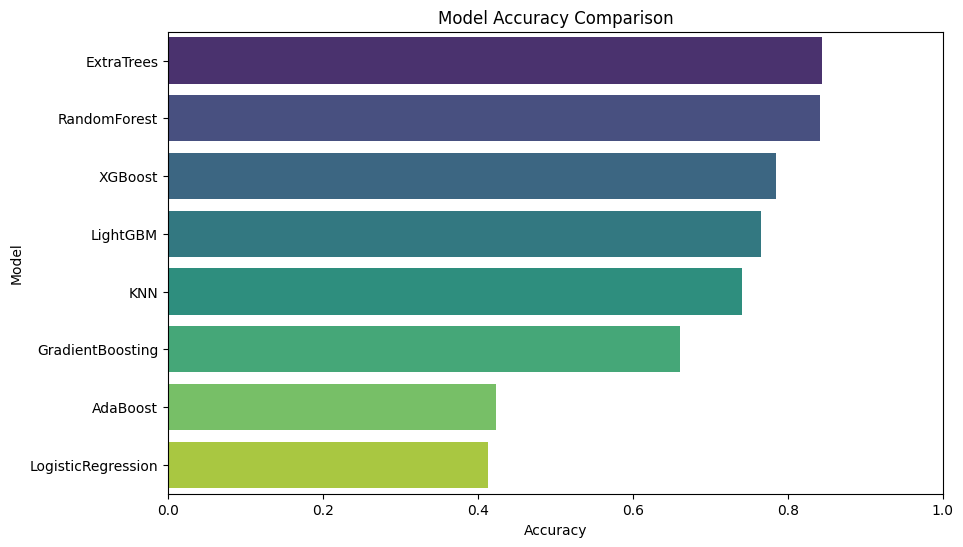

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by accuracy
df_test_metrics = df_test_metrics.sort_values(by='Accuracy', ascending=False)

# Display comparison table
print("✅ Model Comparison Table:")
display(df_test_metrics)

# Plot accuracy comparison
plt.figure(figsize=(10,6))
sns.barplot(x='Accuracy', y='Model', data=df_test_metrics, palette='viridis')
plt.title("Model Accuracy Comparison")
plt.xlim(0,1)
plt.show()


🏆 Top 4 ML models by accuracy: ['ExtraTrees', 'RandomForest', 'XGBoost', 'LightGBM']
✅ Top 4 ML Models Metrics:


,Model,Accuracy,Precision,Recall,F1-score
1,ExtraTrees,0.843600,0.841019,0.843600,0.841974
0,RandomForest,0.840800,0.836752,0.840800,0.837472
4,XGBoost,0.784667,0.780231,0.784667,0.779904
5,LightGBM,0.764933,0.759586,0.764933,0.758415


/tmp/ipython-input-3562513629.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=top_ml_models_df, palette='viridis')


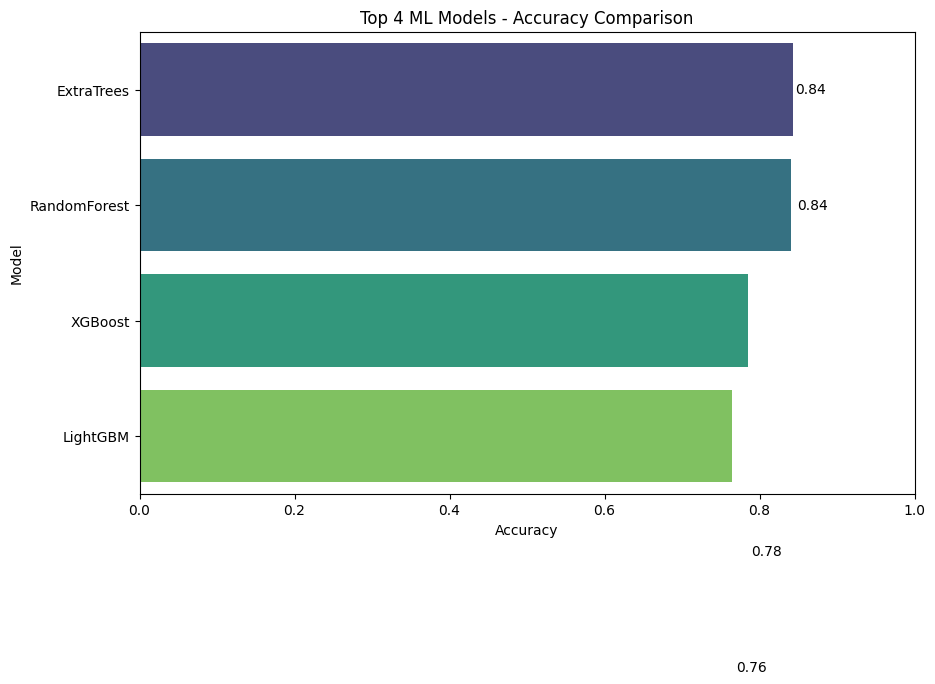

In [30]:
# Filter only ML models (exclude Neural Network models)
ml_model_names = ["RandomForest", "ExtraTrees", "GradientBoosting", "AdaBoost", "XGBoost", "LightGBM", "CatBoost", "LogisticRegression", "KNN"]

# Keep only ML models in test metrics
df_ml_metrics = df_test_metrics[df_test_metrics['Model'].isin(ml_model_names)].copy()

# Select top 4 ML models by Accuracy
top_ml_models_df = df_ml_metrics.sort_values(by='Accuracy', ascending=False).head(4)
top_ml_models = top_ml_models_df['Model'].tolist()
print(f"🏆 Top 4 ML models by accuracy: {top_ml_models}")

# Display comparison table for top 4 ML models
print("✅ Top 4 ML Models Metrics:")
display(top_ml_models_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']])

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x='Accuracy', y='Model', data=top_ml_models_df, palette='viridis')
plt.title("Top 4 ML Models - Accuracy Comparison")
plt.xlim(0,1)
for index, row in top_ml_models_df.iterrows():
    plt.text(row['Accuracy'] + 0.005, index, f"{row['Accuracy']:.2f}", va='center')
plt.show()


In [31]:
df_test_metrics = df_test_metrics.rename(columns={
    "Validation Accuracy": "Accuracy"
})

df_results = df_results.rename(columns={
    "Validation Accuracy": "Accuracy"
})


NameError: name 'df_all_models' is not defined

<Figure size 1200x600 with 0 Axes>